# translating matlab code parser

## setup

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import time

from itertools import groupby
from collections import Counter
from operator import itemgetter

from tqdm import tqdm_notebook, tnrange

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid',rc={'figure.facecolor':'#abb2bf'})

## params

In [3]:
# paths
#lvm_path = Path(r'data/qim_20kbps_10db_l2_v2.lvm')
#lvm_path = Path(r'data/test_packet.lvm')
#lvm_path = Path(r'data/test_data_v2_converted.csv')

#lvm_path = Path(r'data/test-packets/test_data_v2.csv')
#lvm_path = Path(r'data/test-packets/test_data_v2.lvm')
#lvm_path = Path(r'data/test-packets/test_data_v3.lvm')
#lvm_path = Path(r'data/test-packets/test_data_v4.lvm')
#lvm_path = Path(r'data/glaze_data_test.lvm')
#lvm_path = Path(r'data/1556140010292_glaze_data_test.lvm')
lvm_path = Path(r'data/glaze_data_test_v2.lvm')

## class building

In [12]:
class DataParserLVM:
    def __init__(self, lvm_path, source='infer', header=None, preprocess_mode='static', alt=False):
        print('initializing..')
        
        # set input path
        if isinstance(lvm_path, Path):
            try: 
                assert lvm_path.exists()
                self.lvm_path = lvm_path
                print(f'\tset input lvm path: {self.lvm_path}')
            except AssertionError:
                print(f'no file found at {lvm_path}')
                raise                
        else:
            print(f'invalid path {lvm_path}, must be pathlib.Path object')
            raise TypeError
                
        # header
        if header is None:
            #self.header = np.array([1 if i % 2 == 0 else 0 for i in range(30)])
            self.header = np.ones(50, dtype=int)
            print(f'\tset header: {self.header}')
        else:
            if isinstance(header, list):
                self.header = np.array(header)
                print(f'\tset header: {self.header}')
            elif isinstance(header, np.ndarray):
                self.header = header
                print(f'\tset header: {self.header}')
            else:
                print(
                    f'invalid header format specified ({type(header)}), ' + 
                    f'must be np.array or list'
                )
                raise TypeError
        
        # source
        if source == 'txt':
            self.parse_other_file()
        elif source == 'lvm':
            self.parse_lvm_file()            
        elif source == 'csv':
            self.read_csv_data(skiprows=0)
        elif source == 'infer':
            self.sample_input_file(self.lvm_path)
        else:
            print(
                f'invalid source {source}, options are ' + 
                '\'infer\' to sample file and determine best parse method automagically or '
                '\'txt\' for tab delimited numbers only or ' + 
                '\'lvm\' for lvm file with headers or ' + 
                '\'csv\' for csv file with no headers, just data' 
            )
            
        # data message
        #self.data_msg = self.create_data_message()
        self.data_msg = np.array([1,0,1,0,1,0,1,0,1,0])
        self.transitioned_data_msg = np.array([1,0,0,0,1])
        print(f'created data message, {self.data_msg.size} bits')
        
        # startup tasks
        self.preprocess_data(mode=preprocess_mode, alt=alt)
        
    #------------------------------ ingestion and processing ------------------------------
    def create_data_message(self):
        scaler = 1
        base = np.array([1 if i % 2 == 0 else 0 for i in range(20)])
        
        return np.concatenate((
            np.repeat(base, scaler), 
            np.repeat(base, scaler), 
            np.repeat(base, 2*scaler), 
            np.repeat(base, scaler), 
            np.repeat(base, scaler), 
            np.repeat(base, 2*scaler)
        ))
    
    
    def sample_input_file(self, lvm_path):
        # read first 25 lines
        with open(lvm_path, 'r') as infile:
            sample = [
                item
                for line in [
                    next(infile) for _ in range(25)
                ]
                for item in line.strip().split(',')  
                    if len(item) != 0
            ]
            
        file_type = lvm_path.suffix
        
        # evaluate dtypes
        non_floats = 0
    
        for line in sample:
            try:
                float(line)
            except ValueError:
                non_floats += 1
                
        non_float_ratio = non_floats / len(sample)
        print(f'non float count: {non_floats}, ratio: {non_float_ratio:0.2f}')
        
        if non_float_ratio > 0.5:
            if file_type in ['.csv', '.lvm', '.txt']:
                return self.parse_lvm_file()
        else:
            return self.read_csv_data(skiprows=0)            
        
        
    def parse_other_file(self):
        print('parsing tab delimited file..')
        self.raw_data = np.genfromtxt(
            self.lvm_path,
            delimiter='\t',
            usecols=(1)
        )        
        print(f'\timported data, {self.raw_data.size} rows')
        
            
    def parse_lvm_file(self, output_path='auto'):
        """
        reads in .lvm file, writes out .csv with column names
        containing only data points
        
        [arguments]
        input_path: str or pathlib.Path object (preferred)
            input file path
        output_path: 'auto' (preferred) or str or pathlib.Path object
            if auto:
                appends _parsed.csv to end of input file name
            else:
                use provided path, must end in .csv
                
        [returns]
        None
            outputs parsed lvm file
            sets self.parsed_lvm_path, pathlib.Path object pointing to parsed file
        """
        
        print('parsing lvm file..')
        with open(self.lvm_path, 'r') as infile:
            # set output path
            file_name = infile.name
            
            if output_path == 'auto':
                self.parsed_lvm_path = Path(f'{file_name}_parsed.csv')
            else:
                self.parsed_lvm_path = output_path
                
                if isinstance(parsed_lvm_path, Path):
                    try:
                        assert str(parsed_lvm_path).endswith('.csv')
                    except AssertionError:
                        print('output file must end with .csv')
                        raise
                elif isinstance(parsed_lvm_path, str):
                    try:
                        assert parsed_lvm_path.endswith('.csv')
                    except AssertionError:
                        print('output file must end with .csv')
                        raise
                else:
                    print('error, output_path must be str or pathlib.Path object')
                    raise TypeError
            
            if not self.parsed_lvm_path.exists():
                self.parsed_lvm_path.touch()
            
            # find header, store column names
            while True:
                line = infile.readline()
                
                if line.strip().endswith('Comment'):
                    cols = line.split(',')[:-1]
                    print(f'\tcolumns: {cols}')
                    break        
                    
            # trim file and write out
            with open(self.parsed_lvm_path, 'w') as outfile:
                outfile.write(', '.join(cols) + '\n')
                while True:
                    try:
                        outfile.write(next(infile))                        
                    except StopIteration:
                        break
        
        print(f'\tcomplete, parsed file saved to: {self.parsed_lvm_path}')
        self.read_processed_csv_data()
        
        
    def read_processed_csv_data(self):
        print('importing data from parsed csv..')
        self.raw_data = np.genfromtxt(
            self.parsed_lvm_path,
            delimiter=',',
            skip_header=1,
            usecols=(1)
        )
        
        print(f'\timported data, {self.raw_data.size} rows')
        
    def read_csv_data(self, skiprows):
        print('importing data from csv..')
        self.raw_data = np.genfromtxt(
            self.lvm_path,
            delimiter=',',
            skip_header=skiprows,
            usecols=(1)
        )
        
        print(f'\timported data, {self.raw_data.size} rows')
        
        
    def preprocess_data(self, mode='static', alt=False):
        """
        convert float data into 1's and 0's
        
        static: use 1/2 * max data point as threshold
        dynamic: use min + 1/2(max - min) as threshold
        """
        
        if mode == 'static':
            th = self.raw_data.max() / 2
        elif mode == 'dynamic':
            th = self.raw_data.min() + (self.raw_data.max() - self.raw_data.min()) / 2
        elif mode == 'mean':
            th = self.raw_data.mean()
        elif mode == 'absmean':
            th = (np.abs(self.raw_data.max()) + np.abs(self.raw_data.min())) / 2
        else:
            print(f'invalid mode {mode}, options are \'static\' or \'dynamic\' or \'mean\'')
            
        print(f'set th = {th:0.2f}')
        
        shape_check = self.raw_data[np.where(self.raw_data >= th)].size
        #self.original_raw = self.raw_data.copy()
        
        if alt:
            for i in range(self.raw_data.size):
                if self.raw_data[i] >= th:
                    self.raw_data[i] = 1
                else:
                    self.raw_data[i] = 0
            
        else:
            print(f'DEBUG: raw data to convert size: {self.raw_data[np.where(self.raw_data >= th)].size}')
            self.raw_data[np.where(self.raw_data >= th)] = 1
            self.raw_data[np.where(self.raw_data < th)] = 0
        
        print(f'DEBUG: converted raw data sum: {self.raw_data.sum()}')
        
        # set dtype and store
        self.data = self.raw_data.astype('int')
        
        # validate
        try:
            assert self.data.sum() == shape_check            
        except AssertionError:
            print(
                f'error: sum of 1\'s ({self.data.sum()}) does not match ' + 
                f'number of entries >= th ({shape_check})'
            )
        
    #---------------------------------- discretization methods ----------------------------------    
    def get_state_length_list(self, data):
        '''
        takes data list ([1,1,0,1,0,0,...]) and returns numpy array 
        of duration of consecutive bits ([13,245,2588,19,1056,...])
        '''
        
        return np.diff(
            np.where(
                np.concatenate(
                    ([data[0]],
                     data[:-1] != data[1:],
                     [0]
                    )
                )
            )[0]
        )[::2]
    
    def get_correct_state_length_list(self, data):
        '''
        gets state lengths like above, but correctly..
        '''
        
        groups = groupby(data)
        
        return [sum(1 for _ in group) for _, group in groups]
    

    def discretize_signal(self, spb=12):
        start_time = time.time()
        print('discretizing signal..')
        
        # set params
        self.spb = spb
        
        discretized_data = []
        start_bit = self.data[0]
        alt_bit = 0 if start_bit == 1 else 1
        print(f'\tstarting bit: {start_bit}, alt bit: {alt_bit}')
        
        # get state lengths
        #state_lengths = self.get_state_length_list(self.data)
        state_lengths = self.get_correct_state_length_list(self.data)
        
        for i, state in enumerate(state_lengths):
            discretized_state = int(np.round(state / self.spb))
            #print(f'iter: {i}, discretized state: {discretized_state}')
            
            if i % 2 == 0:
                discretized_data.append([start_bit for j in range(discretized_state)])
            elif i % 2 == 1:
                discretized_data.append([alt_bit for j in range(discretized_state)])
            else:
                print('ya done messed up.')
        
        self.discretized_array = np.array([
            item for sublist 
                in discretized_data 
            for item in sublist
        ])
        
        reduction = 100 * (self.discretized_array.size / self.data.size)
        print(
            f'\tcomplete, discretized signal: {self.discretized_array.size} entries ' + 
            f'({reduction:0.2f}% of original)\n'
            f'\tprocessing time: {time.time() - start_time:0.4f} sec'
        )
        
    #---------------------------------- search and ber ----------------------------------
    def search_sequence_numpy(self, arr, seq):
        """ 
        find sequence in an array 
    
        Parameters
        ----------    
        arr    : input 1D array
        seq    : input 1D array
    
        Output
        ------    
        Output : array of starting indices of matches
        """
        
        # validate inputs
        try:
            assert isinstance(arr, np.ndarray)
        except AssertionError:
            print(f'input arr must be numpy array, you provided {type(arr)}')
            raise
            
        try:
            assert isinstance(seq, np.ndarray)
        except AssertionError:
            print(f'input seq must be numpy array, you provided {type(arr)}')
            raise
    
        # Store sizes of input array and sequence
        Na, Nseq = arr.size, seq.size
    
        # Range of sequence
        r_seq = np.arange(Nseq)
    
        # Create a 2D array of sliding indices across the entire length of input array.
        # Match up with the input sequence & get the matching starting indices.
        M = (arr[np.arange(Na-Nseq+1)[:, None] + r_seq] == seq).all(1)
    
        # Get the range of those indices as final output
        if M.any() > 0:
            tmp_array =  np.where(
                np.convolve(
                    M,
                    np.ones((Nseq), dtype=int)
                ) > 0
            )[0]
        else:
            tmp_array =  []
        

        match_starting_idxs = [
            list(map(itemgetter(1), g))[0]
            for k, g in groupby(enumerate(tmp_array), lambda ix: ix[0] - ix[1])
        ]
        
        print(f'found {len(match_starting_idxs)} matches')
        
        return match_starting_idxs

        
        
    def get_signal_stats(self, data):
        state_lengths = self.get_correct_state_length_list(data)
        
        return Counter(state_lengths).most_common()
    
    
    def compute_bit_error_rate(self):
        # find headers
        self.header_starts = self.search_sequence_numpy(self.discretized_array, self.header)
        #print(f'found {len(self.header_starts)} headers')
        
        # slice data packets
        self.ber = []
        clipped_packets = 0
        
        for header in self.header_starts:
            start = header + len(self.header) + 4
            stop = start + len(self.data_msg)
            
            if self.discretized_array[start:stop].size == 160:
                data_slice = self.discretized_array[start:stop]
                self.ber.append((data_slice - self.data_msg).sum())
            else:
                clipped_packets += 1
                
        print(f'complete, found {clipped_packets} clipped packet(s)')
        print(
            f'bit error breakdown:\n' + 
            f'\ttotal messages computed: {len(self.ber)}\n' + 
            f'\tcumulative bit errors: {sum(self.ber)}\n' + 
            f'\tmean bit errors: {sum(self.ber) / len(self.ber)}\n' + 
            f'\tprobably all zero, if not all bit errors are stored in self.ber'
        )
        
    def compute_bit_error_rate_no_header(self):
        self.ber = []
        clipped_packets = 0
        self.data_starts = self.search_sequence_numpy(self.discretized_array, self.data_msg)
        
        for msg in self.data_starts:
            start = msg
            stop = msg + self.data_msg.size
            
            if self.discretized_array[start:stop].size == 10:
                data_slice = self.discretized_array[start:stop]
                self.ber.append((data_slice - self.data_msg).sum())
                
                # transition slice
                #converted = self.transition_data(data_slice)
                #self.ber.append((converted - self.transitioned_data_msg).sum())
                
            else:
                clipped_packets += 1   
                
        print(f'complete, found {clipped_packets} clipped packet(s)')
        print(
            f'bit error breakdown:\n' + 
            f'\ttotal messages computed: {len(self.ber)}\n' + 
            f'\tcumulative bit errors: {sum(self.ber)}\n' + 
            f'\tmean bit errors: {sum(self.ber) / len(self.ber)}\n' + 
            f'\tprobably all zero, if not all bit errors are stored in self.ber'
        )
        
    def transition_data(self, data):
        new_bits = []
        
        for i, elem in enumerate(data):
            if i % 2 == 0:
                prev = elem
            else:
                # if 1 -> 0
                if elem - prev == -1:
                    new_bits.append(1)
                # if 0 -> 1
                if elem - prev == 1:
                    new_bits.append(0)
                    
        return new_bits
        
        
    #---------------------------------- output methods ----------------------------------
    def output_discretized_array(self, output_path='auto', output_format='csv'):
        # set output path
        if output_path == 'auto':
            output_path = Path(r'data/discretized_array.csv')            
        elif isinstance(output_path, Path):
            try:
                assert output_path.parent.exists()
                assert output_path.name.endswith('.csv')
            except AssertionError:
                print(
                    f'parent path ({output_path.parent}) unavailable or ' + 
                    f'path does not end with .csv ({output_path.name}), ' + 
                    f'please choose another path'
                )
                raise
        elif isinstance(output_path, str):
            try:
                output_path = Path(output_path)
                assert output_path.parent.exists()
                assert output_path.name.endswith('.csv')
            except AssertionError:
                print(
                    f'parent path ({output_path.parent}) unavailable or ' + 
                    f'path does not end with .csv ({output_path.name}), ' + 
                    f'please choose another path'
                )
                raise
        else:
            print(
                f'you really messed up, you provided {output_path} {type(output_path)}, ' + 
                f'please provide output_path as str or pathlib.Path object ending with .csv'
            )            
        print(f'set discretized signal output path: {output_path}')
                
        # output
        if output_format == 'csv':
            np.savetxt(
                output_path,
                self.discretized_array,
                delimiter=','
            )
            print(f'\tsuccessfully saved file to: {output_path}')
        else:
            print(f'yeah.. csv is actually the only option.. please try again.')
            raise TypeError
            
    
    #---------------------------------- plotting methods ----------------------------------
    
    def plot_subset(self, data, start, stop):
        plt.figure(figsize=(20, 6))
        
        plt.stem(data[start:stop])
    
    def compare_plots(self, start, stop, title=None):
        if title is None:
            title='no title provided'
        
        fig, ((ax1, ax2)) = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(15,6))
        
        ax1.stem(DP.data[start*DP.spb:stop*DP.spb])
        ax2.stem(DP.discretized_array[start:stop]) 
        
        ax1.set_title(title)
    
        
        
        

## execution

### main

In [13]:
DP = DataParserLVM(
    lvm_path, 
    source='infer',
    preprocess_mode='absmean',
    alt=True
)

initializing..
	set input lvm path: data\glaze_data_test_v2.lvm
	set header: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
non float count: 36, ratio: 0.78
parsing lvm file..
	columns: ['X_Value', 'Voltage']
	complete, parsed file saved to: data\glaze_data_test_v2.lvm_parsed.csv
importing data from parsed csv..
	imported data, 1800000 rows
created data message, 10 bits
set th = 1.28
DEBUG: converted raw data sum: 3407.0


In [14]:
DP.discretize_signal(spb=38)

discretizing signal..
	starting bit: 0, alt bit: 1
	complete, discretized signal: 47350 entries (2.63% of original)
	processing time: 0.2357 sec


In [16]:
DP.compute_bit_error_rate_no_header()

found 14 matches
complete, found 0 clipped packet(s)
bit error breakdown:
	total messages computed: 14
	cumulative bit errors: 0
	mean bit errors: 0.0
	probably all zero, if not all bit errors are stored in self.ber


In [19]:
len(DP.data_starts)

14

### utils

In [ ]:
DP.compare_plots(
    start=9500, 
    stop=11000
)

#### plotting

In [ ]:
DP.plot_subset(
    DP.discretized_array, 
    start=DP.data_starts[0], 
    stop=DP.data_starts[0] + len(DP.data_msg)
)

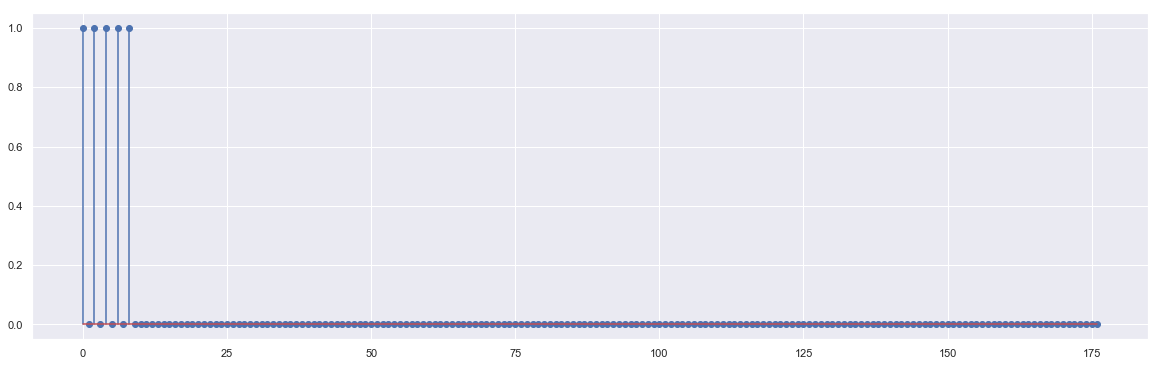

In [52]:
DP.plot_subset(
    DP.discretized_array, 
    start=11823, 
    stop=12000
)

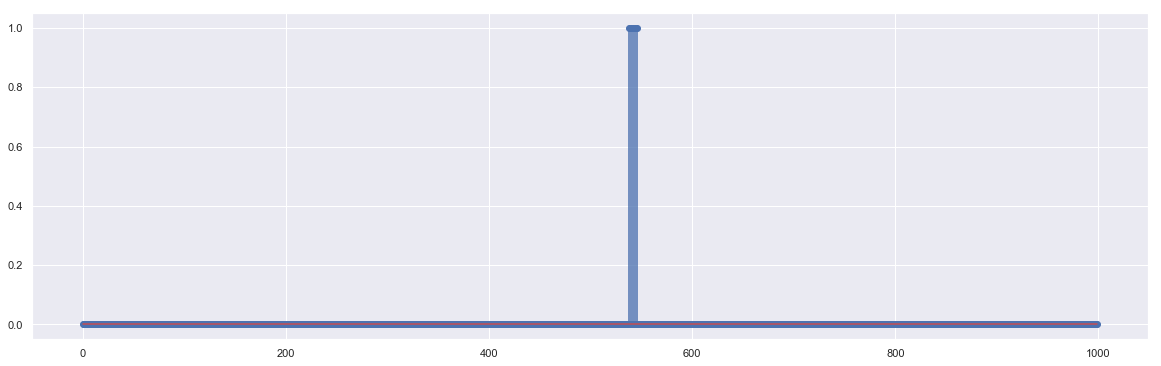

In [39]:
DP.plot_subset(
    DP.discretized_array, 
    start=2000, 
    stop=3000
)

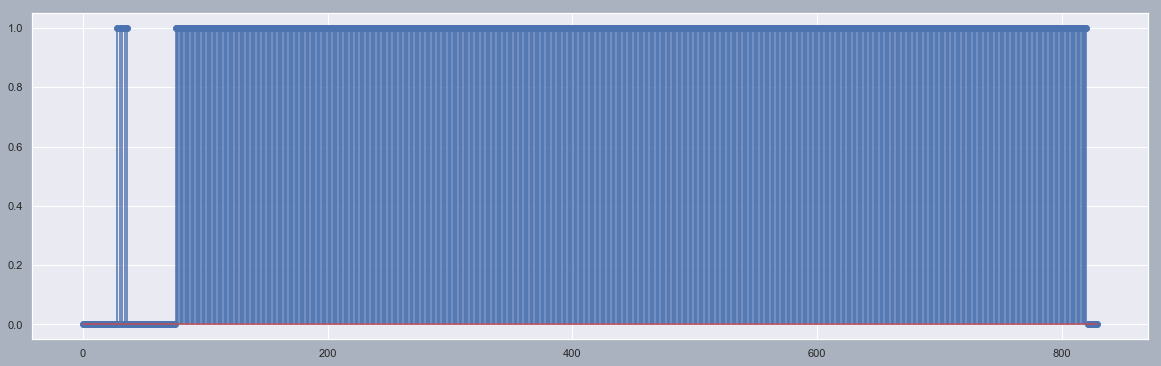

In [59]:
DP.plot_subset(
    DP.discretized_array, 
    start=5870, 
    stop=6700
)

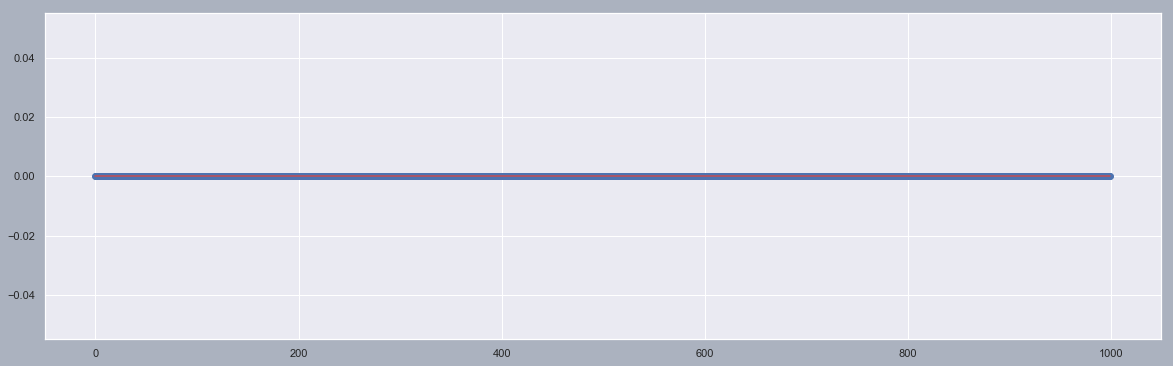

In [37]:
DP.plot_subset(
    DP.data, 
    start=10000, 
    stop=11000
)

#### signal stats

In [38]:
DP.get_signal_stats(DP.data)

[(1, 31),
 (39, 12),
 (43, 10),
 (38, 9),
 (3, 8),
 (41, 8),
 (25, 6),
 (6, 6),
 (7, 6),
 (42, 6),
 (2, 5),
 (9, 5),
 (5, 4),
 (30, 4),
 (40, 4),
 (8, 4),
 (4, 3),
 (50, 2),
 (1387, 2),
 (22, 2),
 (135981, 1),
 (10, 1),
 (31, 1),
 (23, 1),
 (499, 1),
 (27821, 1),
 (58015, 1),
 (1390, 1),
 (28326, 1),
 (58039, 1),
 (37, 1),
 (47, 1),
 (1391, 1),
 (561, 1),
 (27754, 1),
 (58051, 1),
 (1421, 1),
 (28325, 1),
 (58045, 1),
 (44, 1),
 (1413, 1),
 (448, 1),
 (27878, 1),
 (58042, 1),
 (21, 1),
 (631, 1),
 (20329, 1)]